### Tasks

#### figure out a way to make the model deeper 
#### consider small model as low rank representation and project higher. (using outer product) train only small number of outer product parameters - https://arxiv.org/pdf/2012.13255.pdf
#### study the difference between Llama 7B and 33B 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [1]:
import numpy as np
import pandas as pd

dataset = pd.read_csv("Data/HIGGS.csv", header=None)

In [2]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999995,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,...,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999996,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,...,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999997,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,...,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999998,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,...,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [6]:
class HIGGS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

X_train, X_valid, y_train, y_valid = \
    train_test_split(dataset.loc[:, 1:], dataset.loc[:, 0], test_size=1/6, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)


print('X train shape : ', X_train.shape)
print('y train label shape : ', y_train.shape)
print('X valid  shape : ', X_valid.shape)
print('y valid shape: ', y_valid.shape)

X train shape :  (9166666, 28)
y train label shape :  (9166666,)
X valid  shape :  (1833334, 28)
y valid shape:  (1833334,)


In [9]:
train_dataset = HIGGS(X = X_train, y= y_train)
val_dataset = HIGGS(X = X_valid, y = y_valid)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [10]:
dataiter = iter(train_loader)
X, y = next(dataiter)

print('X train shape on PyTorch : ', X.size())
print('y train shape on PyTorch : ', y.size())

X train shape on PyTorch :  torch.Size([128, 28])
y train shape on PyTorch :  torch.Size([128])


In [11]:
from livelossplot import PlotLosses
from collections import defaultdict
device = torch.device("cuda")

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader,
                name):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()
  recordlogs = defaultdict(list)

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()
      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      #print("debug", xb.shape, yb.shape)#, predicted.shape)
      predicted = model(xb.float()).squeeze()
      
      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Compute gradients (autograd).
      loss.backward()
    
      # Count how many correct in batch.
      predicted_ = predicted.detach().sigmoid()
      predicted_ = torch.round(predicted_)
      correct += (predicted_ == yb).sum().cpu().item()
      n_samples += xb.size(0)

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id 
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
    
    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)
    
        # Compute predictions.
        predicted = model(xb.float()).squeeze()

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()
        
        # Count how many correct in batch.
        predicted_ = predicted.detach().sigmoid()
        predicted_ = torch.round(predicted_)
        correct += (predicted_ == yb).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'checkpoints/best_model_so_far_' + name + '.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()
    
    recordlogs['loss'].append(logs['loss'])
    recordlogs['val_loss'].append(logs['loss'])
    recordlogs['accuracy'].append(logs['accuracy'])
    recordlogs['val_accuracy'].append(logs['val_accuracy'])

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()
        
  return recordlogs
  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))    

### Check the performance of small-sized model

In [12]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [13]:
learningRate = 1e-4
modelSmall = MLPSmall()
optimizer = torch.optim.Adam(modelSmall.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelSmall)

MLPSmall(
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [16]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

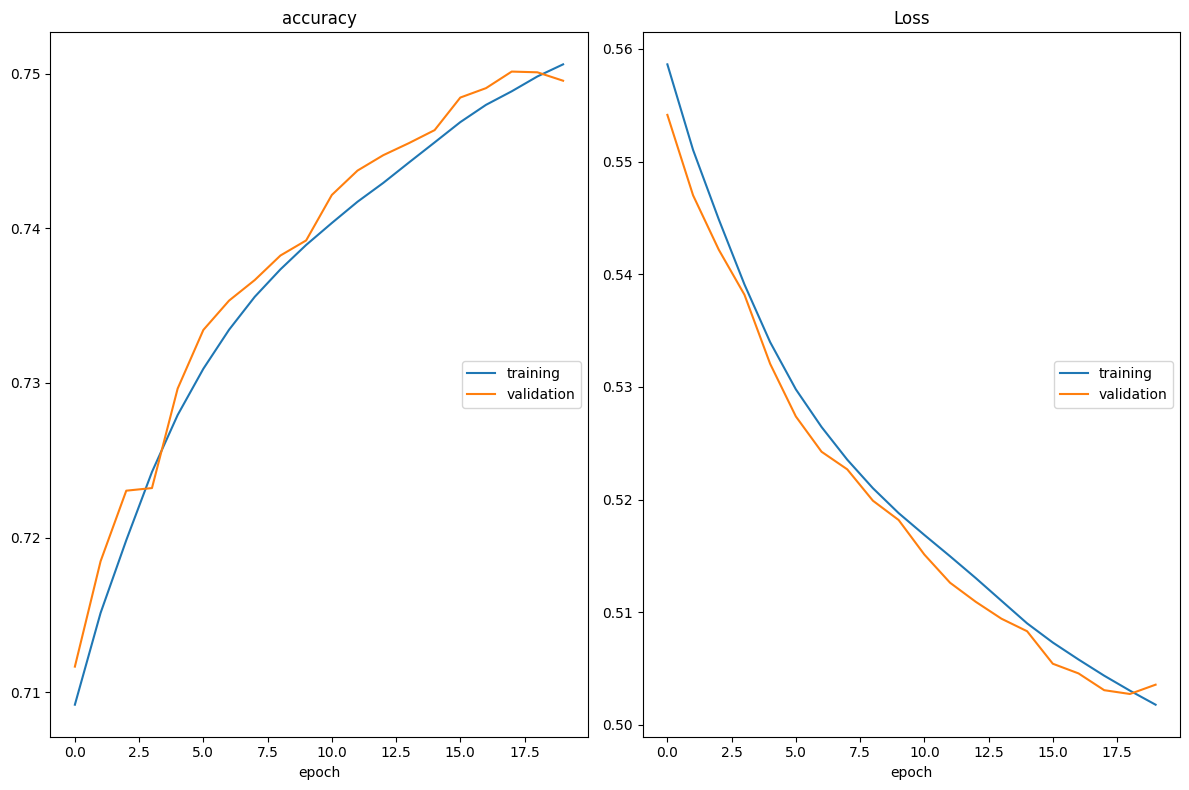

accuracy
	training         	 (min:    0.709, max:    0.751, cur:    0.751)
	validation       	 (min:    0.712, max:    0.750, cur:    0.750)
Loss
	training         	 (min:    0.502, max:    0.559, cur:    0.502)
	validation       	 (min:    0.503, max:    0.554, cur:    0.504)


In [18]:
small_logs = train_model(batch_size, n_epochs, learningRate, 
            modelSmall, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'small-HIGGS');

### Check the performance of medium-sized model

In [19]:
class MLPMedium(nn.Module):
    def __init__(self):
        super(MLPMedium, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [20]:
learningRate = 1e-4
modelMedium = MLPMedium()
optimizer = torch.optim.Adam(modelMedium.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelMedium)

MLPMedium(
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


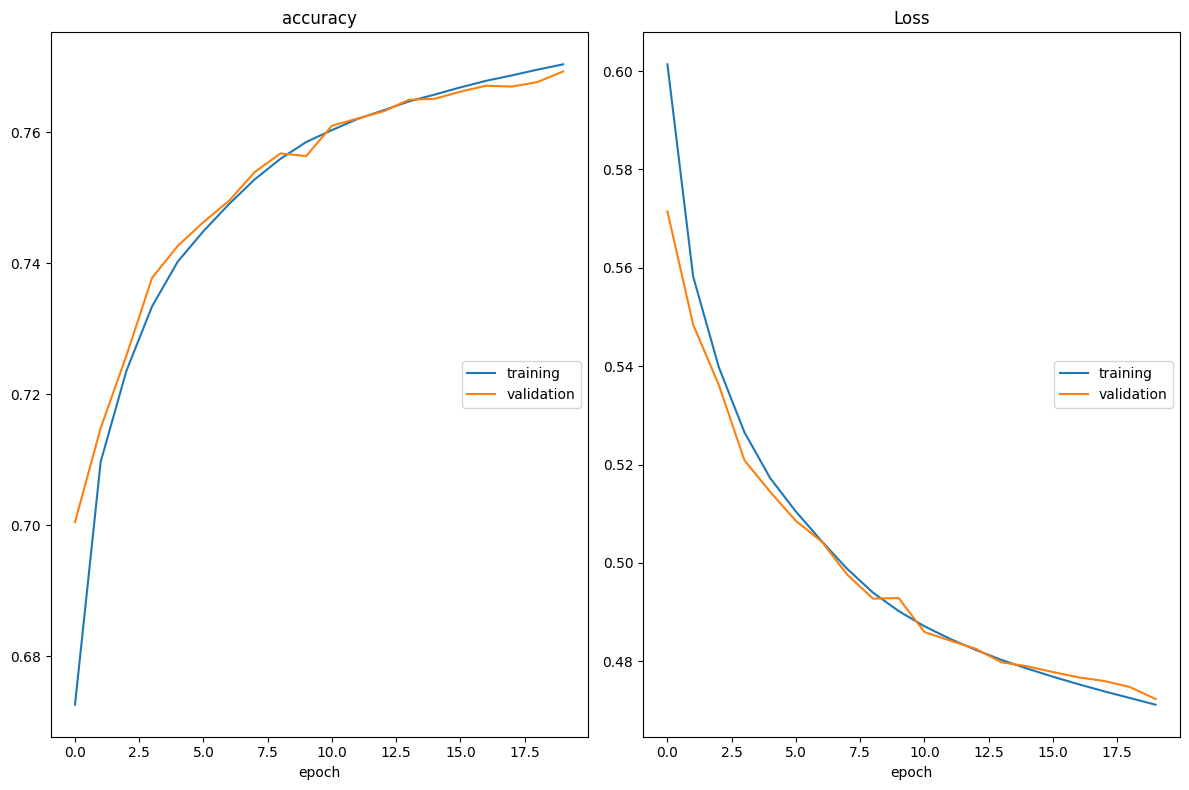

accuracy
	training         	 (min:    0.673, max:    0.770, cur:    0.770)
	validation       	 (min:    0.700, max:    0.769, cur:    0.769)
Loss
	training         	 (min:    0.471, max:    0.601, cur:    0.471)
	validation       	 (min:    0.472, max:    0.571, cur:    0.472)


In [21]:
medium_logs = train_model(batch_size, n_epochs, learningRate, 
            modelMedium, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'medium-HIGGS');

### Densify small model to the same parameters as the medium model

In [22]:
from scipy.stats import ortho_group
class MLPSmalltoMedium(nn.Module):
    def __init__(self, modelSmall):
        super(MLPSmalltoMedium, self).__init__()
        # extract weights from modelSmall
        self.layers = nn.Sequential(
            nn.Linear(28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        for layer in range(len(modelSmall.layers)):
            try:
                tempWeight =  modelSmall.layers[layer].weight.data
                if layer != len(modelSmall.layers) - 1:
                    left = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].out_features), np.s_[modelSmall.layers[layer].out_features:], 1), device=device, dtype=torch.float32)
#                     print("left: " + str(left.size()), "current: " + str(tempWeight.size()))
                    tempWeight = torch.matmul(left, tempWeight)
                if layer != 0:
                    right = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].in_features), np.s_[modelSmall.layers[layer].in_features:], 1), device=device, dtype=torch.float32)
#                     print("current: " + str(tempWeight.size()), "right: " + str(right.T.size()))
                    tempWeight = torch.matmul(tempWeight, right.T)
                
                self.layers[layer].weight.data = tempWeight
                
            
            except Exception as e:
                print("Layer " + str(layer) + ": " + str(e))
                
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [23]:
bestSmallModel = MLPSmall()
bestSmallModel.load_state_dict(torch.load('checkpoints/best_model_so_far_small-HIGGS.pth'))
bestSmallModel = bestSmallModel.to(device)
upscaledModel = MLPSmalltoMedium(bestSmallModel)

Layer 1: 'ReLU' object has no attribute 'weight'
Layer 3: 'ReLU' object has no attribute 'weight'


In [24]:
learningRate = 1e-4
optimizer = torch.optim.Adam(upscaledModel.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(upscaledModel)

MLPSmalltoMedium(
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


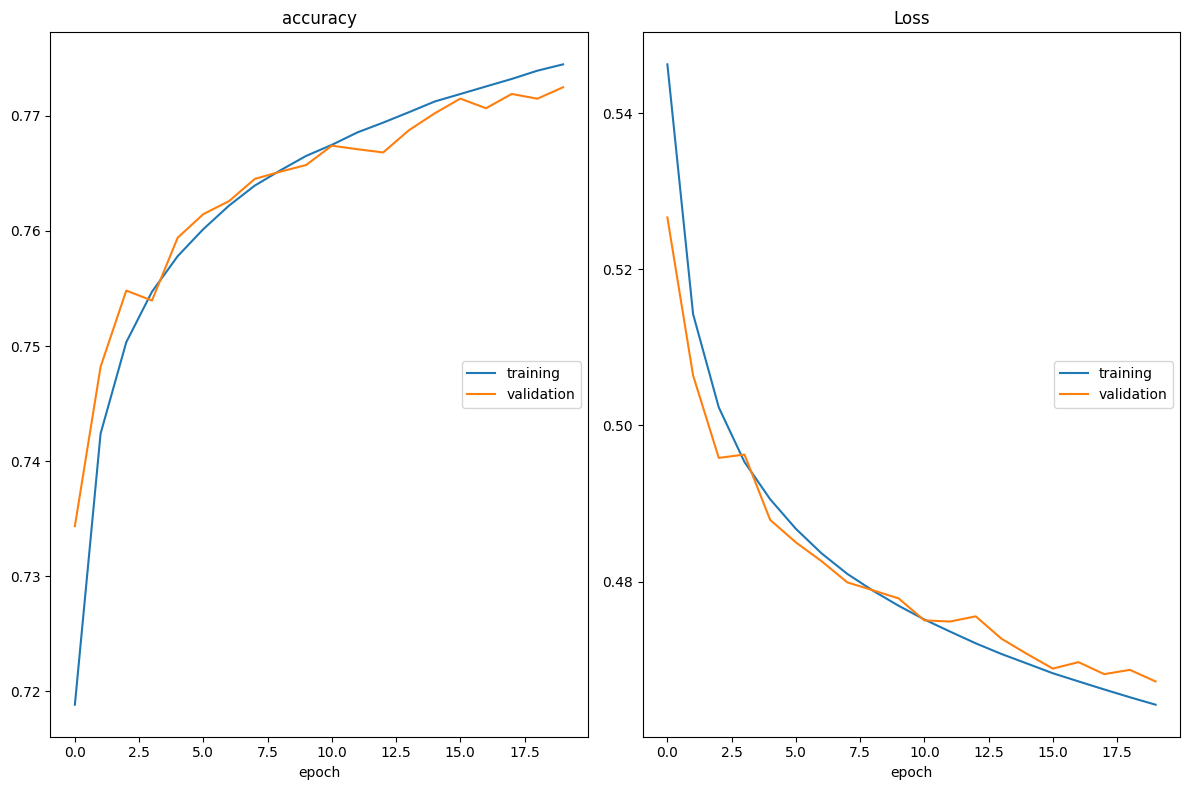

accuracy
	training         	 (min:    0.719, max:    0.774, cur:    0.774)
	validation       	 (min:    0.734, max:    0.772, cur:    0.772)
Loss
	training         	 (min:    0.464, max:    0.546, cur:    0.464)
	validation       	 (min:    0.467, max:    0.527, cur:    0.467)


In [25]:
upscaled_logs = train_model(batch_size, n_epochs, learningRate, 
            upscaledModel, cost_function, optimizer, -1, 
            train_loader, val_loader, name = "upscaled-HIGGS");

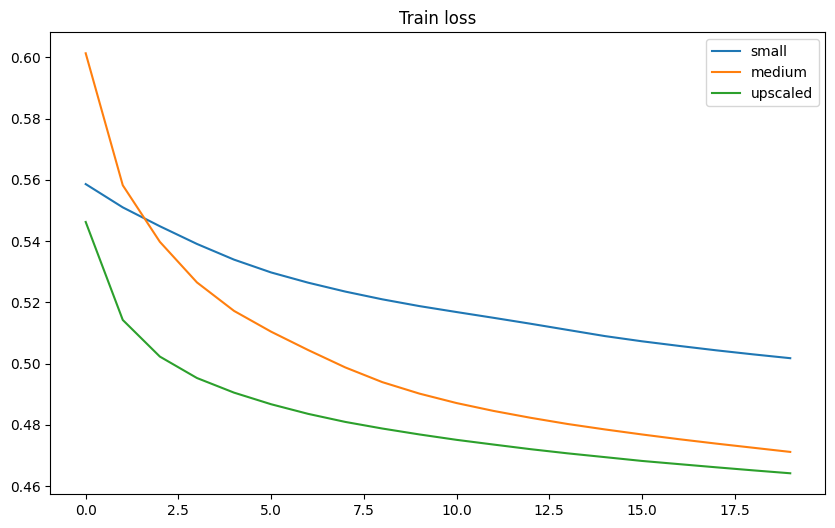

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['loss'])
plt.plot(medium_logs['loss'])
plt.plot(upscaled_logs['loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train loss")

plt.show()

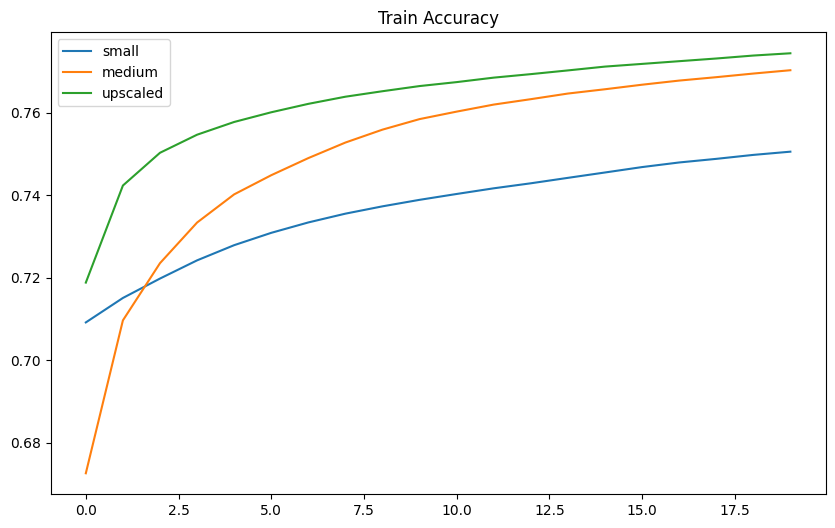

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['accuracy'])
plt.plot(medium_logs['accuracy'])
plt.plot(upscaled_logs['accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train Accuracy")
plt.show()

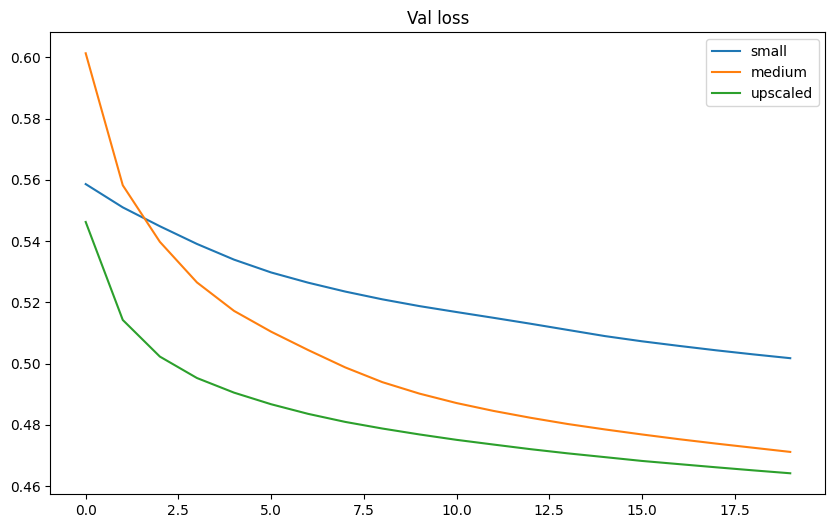

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_loss'])
plt.plot(medium_logs['val_loss'])
plt.plot(upscaled_logs['val_loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val loss")

plt.show()

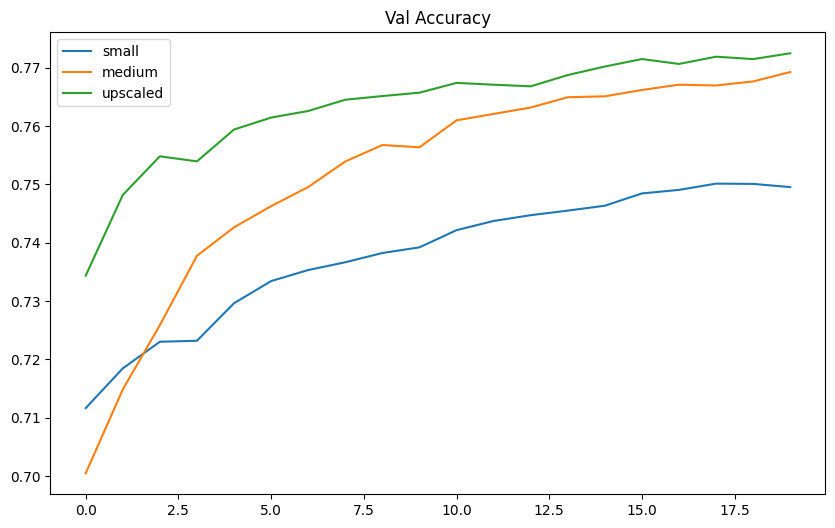

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_accuracy'])
plt.plot(medium_logs['val_accuracy'])
plt.plot(upscaled_logs['val_accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val Accuracy")
plt.show()